In [1]:
#We need to import some required libraries - we do need the models, flatten, dense, input layers 
import numpy as np 
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt
#import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

In [2]:
#Check tensorflow version and keras version. Some seems to give an error. For this, it is working with Tensorflow==2.8 and Keras == 2.8 
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.8.0
2.8.0


In [10]:
#If you are unable to run, mount it to Google Colab instead of running it locally on your machine
#We will then need to mount drive and upload the train-test-split folders to it. 

"""
from google.colab import drive
drive.mount('/content/drive')
"""

ModuleNotFoundError: No module named 'google.colab'

In [5]:
#Install splitfolders to your environment. 
#pip install split-folders using Conda Powershell prompt
#It will split the folders with files eg (images) into train, validation and test (dataset) folders.
#Makes it easier for training, validation and testing. 

import splitfolders
input_folder='pokemon'

splitfolders.ratio(input_folder, output="pokemon_split",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)  
    


ModuleNotFoundError: No module named 'splitfolders'

In [19]:
# Path for train, validation and test dataset. We can use relative path for it. Since split folders have already split the files for us.
train_path = 'pokemon_split/train'
valid_path = 'pokemon_split/val'
test_path = 'pokemon_split/test' 

IMAGE_SIZE = [224, 224] #Default image size for VGG16 

folders = glob('pokemon_split/train*') #Get number of classes (Total should have 5 classes)


# ImageDataGenerator to perform image augmentaion in order to get more diverse dataset. We will perform it on the train dataset. 
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2,rotation_range=30,width_shift_range=0.2,height_shift_range=0.2, horizontal_flip = True,vertical_flip=True)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

#Through flow_from_directory - we create an array of images that can be used for training. 
training_set = train_datagen.flow_from_directory('pokemon_split/train',
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory('pokemon_split/val',
                                                 target_size = (224, 224),
                                                 batch_size = 4,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('pokemon_split/test',
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'categorical')

Found 200 images belonging to 5 classes.
Found 25 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


We know we have a total of 250 images. Since we split them into 3 files. The numbers seems to be correct. We have 5 classes aka 5 different types of pokemon and with the ratio that we implemented. 

(4, 224, 224, 3)


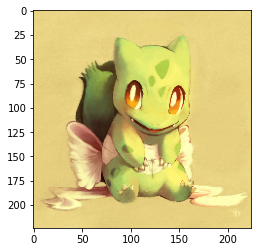

(4, 224, 224, 3)


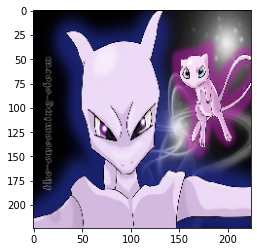

(4, 224, 224, 3)


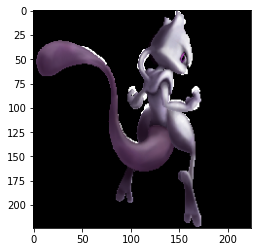

(4, 224, 224, 3)


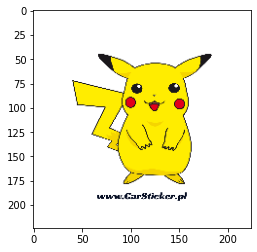

(4, 224, 224, 3)


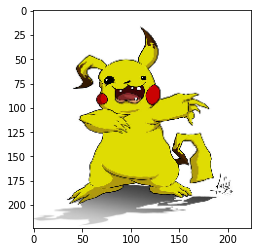

In [4]:
#Look at the pictures of the pokemon to get a feel
for i in range(5):
    img,label=test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [5]:
#Original code. Creatation of VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. Transfer VGG and freeze image 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights

# Creation of VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. We will just use VGG16 network for training. 
#vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(5, activation='softmax')(x) # We have 5 classes, so we set it to 5. For this model, we will just set as one dense layer. 

#Creating model object 
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
for i, layer in enumerate(model.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))


Layer 0: input_1 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (False)
Layer 16: block5_conv2 (False)
Layer 17: block5_conv3 (False)
Layer 18: block5_pool (False)
Layer 19: flatten (True)
Layer 20: dense (True)


We can see that we have freeze our model. The only layers that we are trianing is Layer 19 and Layer 20. 
Once we preload the VGG16 model, we can choose to freeze the "deep layers" of the model and only re-train the last few layers on our own data. This is common transfer learning strategy and is often a good approach when the amount of training data is limited. 

In [7]:
#Compile the model and do the training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model.fit(training_set, validation_data=validation_set, epochs=20, batch_size=2,shuffle=True,verbose=1)


Epoch 1/20
32/50 [==================>...........] - ETA: 11s - loss: 3.3718 - accuracy: 0.2734

C:\Users\icyro\anaconda3\envs\dl\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - 36s 698ms/step - loss: 2.8554 - accuracy: 0.3300 - val_loss: 2.6819 - val_accuracy: 0.3462
Epoch 2/20
50/50 [==============================] - 34s 670ms/step - loss: 1.2638 - accuracy: 0.5750 - val_loss: 1.7638 - val_accuracy: 0.4231
Epoch 3/20
50/50 [==============================] - 33s 654ms/step - loss: 0.6660 - accuracy: 0.7700 - val_loss: 1.2687 - val_accuracy: 0.6154
Epoch 4/20
50/50 [==============================] - 32s 631ms/step - loss: 0.6428 - accuracy: 0.7800 - val_loss: 1.8716 - val_accuracy: 0.5385
Epoch 5/20
50/50 [==============================] - 37s 744ms/step - loss: 0.7406 - accuracy: 0.7500 - val_loss: 1.5108 - val_accuracy: 0.5769
Epoch 6/20
50/50 [==============================] - 36s 725ms/step - loss: 0.5597 - accuracy: 0.7900 - val_loss: 2.9739 - val_accuracy: 0.4231
Epoch 7/20
50/50 [==============================] - 34s 667ms/step - loss: 0.6374 - accuracy: 0.7950 - val_loss: 1.6094 - val_accuracy: 0.6154
Epoch 8/20

We can get around accuracy of 0.93, val_loss of 2.89 and val_accuracy of 0.61 for Adam.

In [11]:
#print(history.history.keys())

In [8]:
print(history.history['val_loss'])

[2.681898593902588, 1.7637921571731567, 1.2686679363250732, 1.8716223239898682, 1.5107964277267456, 2.973924398422241, 1.6094489097595215, 2.563894510269165, 1.8411661386489868, 2.037036657333374, 1.9193413257598877, 2.5026206970214844, 2.211564302444458, 2.1045033931732178, 2.0642495155334473, 1.9598376750946045, 2.8172199726104736, 2.3670871257781982, 2.794003486633301, 2.899806022644043]


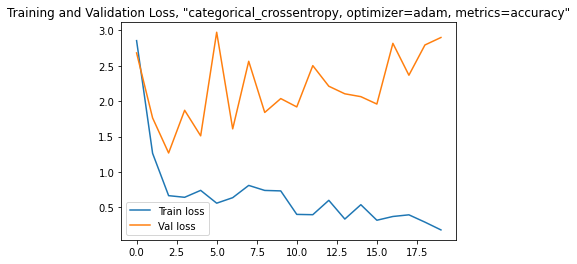

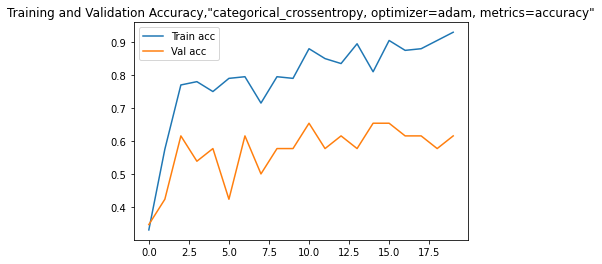

<Figure size 432x288 with 0 Axes>

In [9]:
#Check plot for training and validation loss 

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training and Validation Loss, "categorical_crossentropy, optimizer=adam, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Training and Validation Accuracy,"categorical_crossentropy, optimizer=adam, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


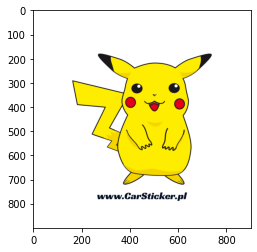

Who's that Pokemon? It's ['pikachu']
It is in class: [3]


In [202]:
from keras.models import load_model
import cv2
import numpy as np
class_names=['bulbasaur','charmander','mewtwo','pikachu','squrtile']
model = load_model('model_adam.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
#Input your test picture here using relative path#

#img=cv2.imread('pokemon_split/val/charmander/00000202.jpg')

img=cv2.imread('pokemon_split/test/pikachu/00000220.png')[...,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

classes =np.argmax(model.predict(img),axis=-1)
names=[class_names[i] for i in classes]

#print (classes)
#print(names)
print("Who's that Pokemon? It's", names)
print("It is in class:", classes)




In [161]:
model.predict(img)

array([[0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
#Saving the adam model 
model.save('model_adam.h5')


In [86]:
test_set = test_datagen.flow_from_directory('pokemon_split/test',
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'categorical')

Found 25 images belonging to 5 classes.


In [11]:
#We can use this code to check how well our model is at predicting using our test set, which the model did not see before. 

test_history=model.evaluate_generator(test_set,20,verbose=1)
print('Accuracy for testing is ',test_history[1])

C:\Users\icyro\AppData\Local\Temp\ipykernel_28304\479716016.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_history=model.evaluate_generator(test_set,20,verbose=1)


20/20 [==============================] - 7s 329ms/step - loss: 1.3758 - accuracy: 0.7200
Accuracy for testing is  0.7200000286102295


We can get around 0.72 accuracy for out test dataset. 

Let us try another way, this time we will use mean_squared_logarithmic_error', optimizer='SGD'

In [164]:
# Create a VGG16 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights

# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
#vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) 

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
prediction = Dense(5, activation='softmax')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes

#Creating model object 
model2 = Model(inputs=vgg.input, outputs=prediction)

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [167]:
for i, layer in enumerate(model2.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_4 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (False)
Layer 16: block5_conv2 (False)
Layer 17: block5_conv3 (False)
Layer 18: block5_pool (False)
Layer 19: flatten_2 (True)
Layer 20: dense_2 (True)


In [168]:
#Compile the model 
model2.compile(loss='mean_squared_logarithmic_error', optimizer='SGD', metrics=['accuracy']) 
history = model2.fit(training_set, validation_data=validation_set, epochs=20, batch_size=2,shuffle=True,verbose=1)


Epoch 1/20
30/50 [=================>............] - ETA: 14s - loss: 0.0910 - accuracy: 0.1833

C:\Users\icyro\anaconda3\envs\dl\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - 44s 850ms/step - loss: 0.0852 - accuracy: 0.2600 - val_loss: 0.0909 - val_accuracy: 0.2800
Epoch 2/20
50/50 [==============================] - 42s 837ms/step - loss: 0.0741 - accuracy: 0.3950 - val_loss: 0.0872 - val_accuracy: 0.2000
Epoch 3/20
50/50 [==============================] - 42s 842ms/step - loss: 0.0680 - accuracy: 0.4550 - val_loss: 0.0706 - val_accuracy: 0.3200
Epoch 4/20
50/50 [==============================] - 41s 829ms/step - loss: 0.0520 - accuracy: 0.5800 - val_loss: 0.0720 - val_accuracy: 0.4400
Epoch 5/20
50/50 [==============================] - 42s 840ms/step - loss: 0.0453 - accuracy: 0.6700 - val_loss: 0.0650 - val_accuracy: 0.4800
Epoch 6/20
50/50 [==============================] - 42s 831ms/step - loss: 0.0374 - accuracy: 0.7700 - val_loss: 0.0656 - val_accuracy: 0.4800
Epoch 7/20
50/50 [==============================] - 42s 837ms/step - loss: 0.0344 - accuracy: 0.7750 - val_loss: 0.0511 - val_accuracy: 0.6000
Epoch 8/20

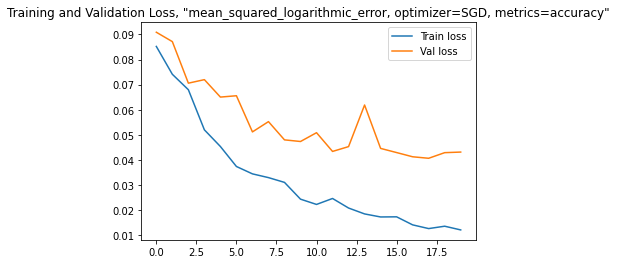

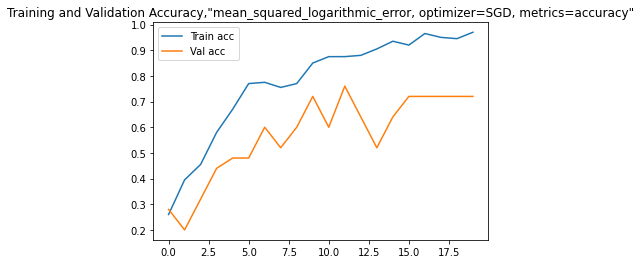

<Figure size 432x288 with 0 Axes>

In [172]:
#Plot the graph to see how is our training and if we need to further optimize it. 


plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training and Validation Loss, "mean_squared_logarithmic_error, optimizer=SGD, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Training and Validation Accuracy,"mean_squared_logarithmic_error, optimizer=SGD, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [169]:
#Save the model 
model2.save('model_sgd_rms.h5')


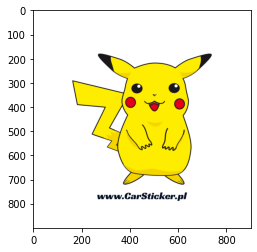

Who's That Pokemon? It's ['pikachu']
It is in class: [3]


In [199]:
from keras.models import load_model
import cv2
import numpy as np
class_names=['bulbasaur','charmander','mewtwo','pikachu','squrtile']
model = load_model('model_sgd_rms.h5')
model.compile(loss='mean_squared_logarithmic_error',
              optimizer='SGD',
              metrics=['accuracy'])
              

#OpenCV use BGR as its default colour, easiest way of fixing it is to use OpenCV to convert it back to RGB

#img=cv2.imread('pokemon_split/val/mewtwo/00000207.jpg')

#Input your test picture here using relative path
#We can view the image that we want to predict as well as tell us which Pokemon it is. Or just to check if it is correct
img=cv2.imread('pokemon_split/test/pikachu/00000220.png')[...,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

classes =np.argmax(model.predict(img),axis=-1)
names=[class_names[i] for i in classes]

#print (classes)
#print(names)
print("Who's That Pokemon? It's", names)
print("It is in class:", classes)



In [174]:
test_history=model.evaluate_generator(test_set,20,verbose=1)
print('Accuracy for testing is ',test_history[1])

C:\Users\icyro\AppData\Roaming\MobaXterm\slash\var\log\xwin\ipykernel_9320\290596330.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_history=model.evaluate_generator(test_set,20,verbose=1)


20/20 [==============================] - 5s 206ms/step - loss: 0.0475 - accuracy: 0.6000
Accuracy for testing is  0.6000000238418579


Final evaluation and conclusion
We can achieve some what good results, accuracy of 0.56-0.6 on untrained data. Might need to add more to the dense layer or changing the learning rate to get better results.

In [31]:
import keras
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
x = keras.layers.Dense(4096, activation='relu')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes
x = keras.layers.Dense(4096, activation='relu')(x) 
prediction = Dense(5, activation='softmax')(x) # We have 5 classes

#Creating model object 
model3 = Model(inputs=vgg.input, outputs=prediction)

model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
for i, layer in enumerate(model3.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_6 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (False)
Layer 16: block5_conv2 (False)
Layer 17: block5_conv3 (False)
Layer 18: block5_pool (False)
Layer 19: flatten_6 (True)
Layer 20: dense_13 (True)
Layer 21: dense_14 (True)
Layer 22: dense_15 (True)


In [33]:
#Compile the model and do the training
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model3.fit(training_set, validation_data=validation_set, epochs=20, batch_size=2,shuffle=True,verbose=1)

Epoch 1/20
50/50 [==============================] - 52s 1s/step - loss: 6.0516 - accuracy: 0.2350 - val_loss: 1.8089 - val_accuracy: 0.2692
Epoch 2/20
50/50 [==============================] - 50s 1s/step - loss: 1.3434 - accuracy: 0.5150 - val_loss: 1.5833 - val_accuracy: 0.3846
Epoch 3/20
50/50 [==============================] - 52s 1s/step - loss: 1.0079 - accuracy: 0.6050 - val_loss: 1.8887 - val_accuracy: 0.5385
Epoch 4/20
50/50 [==============================] - 52s 1s/step - loss: 0.8590 - accuracy: 0.6500 - val_loss: 1.7825 - val_accuracy: 0.4615
Epoch 5/20
50/50 [==============================] - 52s 1s/step - loss: 0.7217 - accuracy: 0.7400 - val_loss: 2.1821 - val_accuracy: 0.4615
Epoch 6/20
50/50 [==============================] - 52s 1s/step - loss: 0.9388 - accuracy: 0.6750 - val_loss: 1.1237 - val_accuracy: 0.5769
Epoch 7/20
50/50 [==============================] - 53s 1s/step - loss: 0.6615 - accuracy: 0.7500 - val_loss: 1.7312 - val_accuracy: 0.6538
Epoch 8/20
50/50 [==

In [34]:
model3.save('model3.h5')

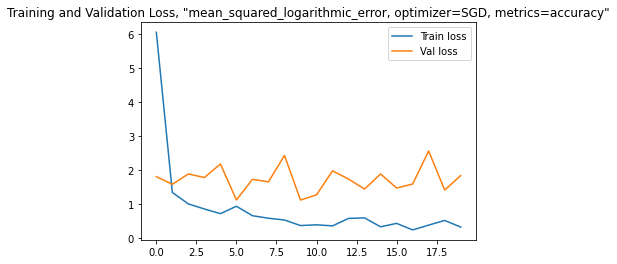

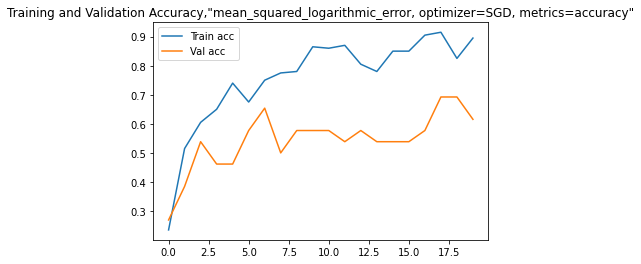

<Figure size 432x288 with 0 Axes>

In [35]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training and Validation Loss, "mean_squared_logarithmic_error, optimizer=SGD, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Training and Validation Accuracy,"mean_squared_logarithmic_error, optimizer=SGD, metrics=accuracy"')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


In [41]:
test_history=model3.evaluate_generator(test_set,25,verbose=1)
print('Accuracy for testing is ',test_history)

C:\Users\icyro\AppData\Local\Temp\ipykernel_24784\3590095126.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_history=model3.evaluate_generator(test_set,25,verbose=1)


25/25 [==============================] - 4s 134ms/step - loss: 1.5474 - accuracy: 0.6000
Accuracy for testing is  [1.54740571975708, 0.6000000238418579]


In [47]:
import keras
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False) #Training with Imagenet weights

for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened. 
x = keras.layers.Dense(512, activation='relu')(x) # Try with 512 neurons instead 
x = keras.layers.Dense(512, activation='relu')(x) 
prediction = Dense(5, activation='softmax')(x) # We have 5 classes

#Creating model object 
model4 = Model(inputs=vgg.input, outputs=prediction)

model4.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [48]:
for i, layer in enumerate(model4.layers):
    print('Layer {}: {} ({})'.format(i, layer.name, layer.trainable))

Layer 0: input_11 (False)
Layer 1: block1_conv1 (False)
Layer 2: block1_conv2 (False)
Layer 3: block1_pool (False)
Layer 4: block2_conv1 (False)
Layer 5: block2_conv2 (False)
Layer 6: block2_pool (False)
Layer 7: block3_conv1 (False)
Layer 8: block3_conv2 (False)
Layer 9: block3_conv3 (False)
Layer 10: block3_pool (False)
Layer 11: block4_conv1 (False)
Layer 12: block4_conv2 (False)
Layer 13: block4_conv3 (False)
Layer 14: block4_pool (False)
Layer 15: block5_conv1 (False)
Layer 16: block5_conv2 (False)
Layer 17: block5_conv3 (False)
Layer 18: block5_pool (False)
Layer 19: flatten_11 (True)
Layer 20: dense_23 (True)
Layer 21: dense_24 (True)
Layer 22: dense_25 (True)


In [49]:
#Compile the model and do the training
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
history = model4.fit(training_set, validation_data=validation_set, epochs=40, batch_size=2,shuffle=True,verbose=1)

Epoch 1/40
35/50 [====================>.........] - ETA: 9s - loss: 3.0238 - accuracy: 0.2929

C:\Users\icyro\anaconda3\envs\dl\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


50/50 [==============================] - 36s 698ms/step - loss: 2.6369 - accuracy: 0.3400 - val_loss: 1.6453 - val_accuracy: 0.3846
Epoch 2/40
50/50 [==============================] - 40s 804ms/step - loss: 1.1850 - accuracy: 0.5350 - val_loss: 1.4438 - val_accuracy: 0.5000
Epoch 3/40
50/50 [==============================] - 39s 777ms/step - loss: 0.9436 - accuracy: 0.6350 - val_loss: 1.9162 - val_accuracy: 0.3462
Epoch 4/40
50/50 [==============================] - 39s 772ms/step - loss: 0.9646 - accuracy: 0.6450 - val_loss: 1.2446 - val_accuracy: 0.5000
Epoch 5/40
50/50 [==============================] - 41s 816ms/step - loss: 0.7252 - accuracy: 0.7250 - val_loss: 1.1203 - val_accuracy: 0.5769
Epoch 6/40
50/50 [==============================] - 36s 718ms/step - loss: 0.5799 - accuracy: 0.7750 - val_loss: 1.2545 - val_accuracy: 0.6154
Epoch 7/40
50/50 [==============================] - 34s 679ms/step - loss: 0.6071 - accuracy: 0.7850 - val_loss: 0.8660 - val_accuracy: 0.7308
Epoch 8/40

In [50]:
model4.save('model4.h5')

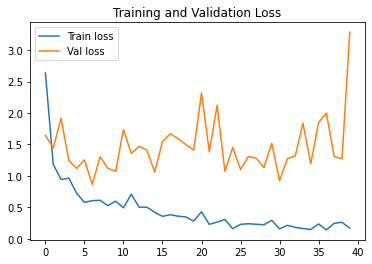

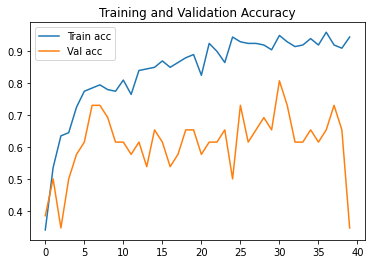

<Figure size 432x288 with 0 Axes>

In [51]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title('Training and Validation Loss' )
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')


Was doing well until we see a sharp drop at 40 epoch. We can see that the accuracy is around 0.8-0.9, which is quite accrate for such a small dataset.

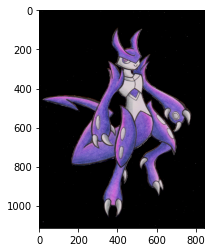

Who's That Pokemon? It's ['mewtwo']
It is in class: [2]


In [18]:
from keras.models import load_model
import cv2
import numpy as np
class_names=['bulbasaur','charmander','mewtwo','pikachu','squrtile']
model = load_model('model.h5')
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              

#OpenCV use BGR as its default colour, easiest way of fixing it is to use OpenCV to convert it back to RGB

#img=cv2.imread('pokemon_split/val/mewtwo/00000207.jpg')

#Input your test picture here using relative path
#We can view the image that we want to predict as well as tell us which Pokemon it is. Or just to check if it is correct
img=cv2.imread('pokemon_split/val/mewtwo/00000205.png')[...,::-1]
plt.imshow(img)
plt.show()
img = cv2.resize(img,(224,224))
img = np.reshape(img,[1,224,224,3])

classes =np.argmax(model.predict(img),axis=-1)
names=[class_names[i] for i in classes]

#print (classes)
#print(names)
print("Who's That Pokemon? It's", names)
print("It is in class:", classes)

Final evaluation and conclusion 
In conlusion, it seems that the model performs the best is the model3 model, with 3 dense layer of 4092 units. All these models can predict relatively well although we have limited data sets, total 250 images for 5 classes of Pokemon. some predictions might not be that accurate, specially if the Pokemon have quite similar shapes(Mewtwo and Bulbasaur looks the same althought colours will tell them part) .If we have slightly more data, I am sure transfer learning will be more effective. However,transfer learning is a effect way to build a deep neural network with such limited dataset. 